# Cells size experiment

Experimental design helps you decide the number of replicates you need to relibably detect effects in your experiment. 
In this example we going to look at changes in the size of cell by measuring it's area.

First we need to import some packages for doing maths and plotting

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from helper_functions import *

## 1. Measuring the size of the cells

The first step is to measure the area of the cells. Below is a phase contrast picture of the 3T3 cells before treatement.  The cells were detected in FIJI using a short script and the information about each Region of Interest (ROI) exported as a `.csv` file. 

![](media/detect.png)

# Reading in the data about the cells

The sizes from of the intial time points were saved into a set `.csv files` for each field of view and time point.  This code reads in the data and organises it into a nice neat table:

In [5]:
df =read_data()

In [6]:
df.head()

,,Area,X,Y,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Circ.,AR,Round,Solidity,Time
0,1,495.783,273.210,55.699,146.244,258.924,35.208,30.440,38.875,35.397,17.834,117.459,0.291,1.985,0.504,0.695,1
1,2,463.502,472.280,64.761,114.873,453.667,53.178,37.042,24.572,30.632,19.266,23.603,0.441,1.590,0.629,0.732,1
2,3,414.542,347.846,82.791,130.669,331.174,73.716,41.443,19.071,36.408,14.497,4.068,0.305,2.511,0.398,0.643,1
3,4,1057.472,528.469,128.270,224.004,505.746,97.922,39.976,63.447,52.267,25.761,108.483,0.265,2.029,0.493,0.643,1
4,5,3867.265,446.777,163.193,998.925,379.584,100.122,136.797,122.494,129.187,38.115,129.794,0.049,3.389,0.295,0.466,1


## What is distribution of the  size of the cells?

The first we need to know is what the spread or distribution of cell sizes are in the population.  Here are plots of the area of the cells for two time points to give us an idea of the shape of the distributions.

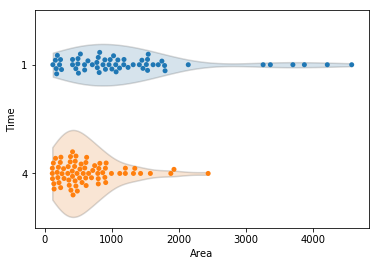

In [7]:
fig,ax=plt.subplots()
sns.violinplot(x="Area",y='Time',cut=0,inner=None,data=df)
sns.swarmplot(x="Area",y='Time',data=df)
setAlpha(ax,0.2)

A common way to describe the size of cells is the log-normal distribution.  This is simply a normal distribution on a log scale.  

Compared to the more familar normal distribution, the log-normal more realisitic for describing the size of cells as it cannot be negative.  To demonstrate this we fit the normal and log-normal distributions to the area data 

In [8]:
mask = df['Time']==1
ln_param=stats.lognorm.fit(df[mask]['Area'],floc=0)
nm_param=stats.norm.fit   (df[mask]['Area'])

Plotting the distributions highlights that the problem with the normal disrtibution:
* a signficant number of cells with negative area
* probably not enough cells with large area

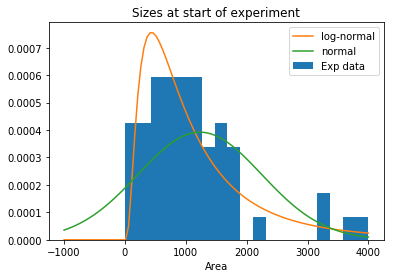

In [9]:
x = np.linspace(-1000,4000,100)

plt.hist(df[mask]['Area'], bins=np.linspace(0,4000,20),density=True,    label="Exp data")
plt.plot(x,stats.lognorm.pdf(x,ln_param[0]  ,scale=ln_param[2]),   label="log-normal")
plt.plot(x,stats.norm.pdf   (x,loc=nm_param[0],scale=nm_param[1]), label="normal")
plt.xlabel("Area")
plt.title("Sizes at start of experiment")
plt.legend()

The fit is repeated for the cell sizes after treament

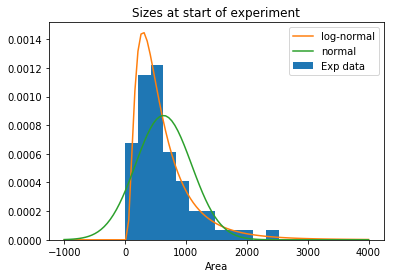

In [10]:
mask = df['Time']==4
ln_param=stats.lognorm.fit(df[mask]['Area'],floc=0)
nm_param=stats.norm.fit   (df[mask]['Area'])
x = np.linspace(-1000,4000,100)
plt.hist(df[mask]['Area'], bins=np.linspace(0,4000,20),density=True,     label="Exp data")
plt.plot(x,stats.lognorm.pdf(x,ln_param[0]  ,scale=ln_param[2]),  label="log-normal")
plt.plot(x,stats.norm.pdf   (x,loc=nm_param[0],scale=nm_param[1]),label="normal")
plt.xlabel("Area")
plt.title("Sizes at start of experiment")
plt.legend()

## Making fake data

The whole point of the previous section was to enable us to make up realistic 'fake' data for running simulations.  Using the information from above here is a function that makes fake data sets

In [11]:
def gen_fake_data( nsamp=65, f_red=0.55 ):
    Nc = stats.poisson.rvs(nsamp)
    Nt=Nc
    area_c = stats.lognorm.rvs( 0.78, scale=      890, size=Nc)
    area_t = stats.lognorm.rvs( 0.78, scale=f_red*890, size=Nt)
    df = pd.concat(map(pd.DataFrame, [{'Area':area_c,'Time':0 },{'Area':area_t,'Time':4}]))
    df ['Time']=pd.Categorical(df['Time'])
    return df

Now lets compare it to the observed data

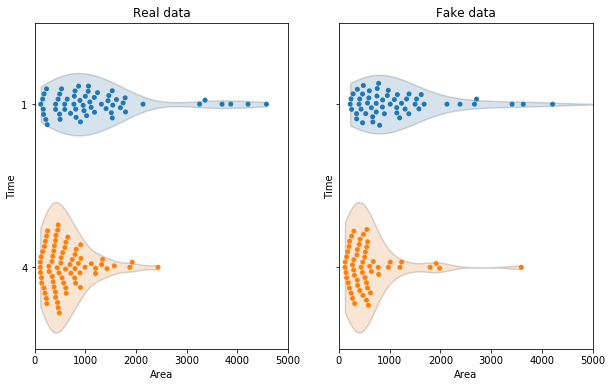

In [12]:
dfx = gen_fake_data(nsamp=65)

fig,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,6))
sns.violinplot(x="Area",y='Time',inner=None,cut=0,data=dfx, ax=axs[1])
sns.swarmplot(x="Area",y='Time',data=dfx,ax=axs[1])
setAlpha(axs[1],0.2)
axs[1].set_title("Fake data")

sns.violinplot(x="Area",y='Time',inner=None,cut=0,data=df, ax=axs[0])
sns.swarmplot(x="Area",y='Time',data=df,ax=axs[0])
axs[0].set_xlim(0,5000)
axs[0].set_title("Real data")
setAlpha(axs[0],0.2)

## Statistical tests

One of the important things to report from your experiement is what is chance that your results could be due to chance alone.  This commonly done using statitisical test and reported as a p-value.  




In [14]:
dfx = gen_fake_data(nsamp=65,f_red=0.5)
area_c = dfx[dfx['Time']==0]['Area']
area_t = dfx[dfx['Time']==4]['Area']
outp=stats.ttest_ind(area_c, area_t)
print(outp)

Ttest_indResult(statistic=4.2042839465155275, pvalue=4.797432145544214e-05)


In [15]:
stats.mannwhitneyu(area_c, area_t,alternative='two-sided').pvalue

2.625516059483616e-07

Now we going to simulate doing the experiment with different number of fields of view

In [18]:
size_ratio = 0.6
sample_sizes= [10,20,30,40,50,60,70,80,90,100]
nrep =100

ttest_pvals=np.zeros([len(sample_sizes),nrep,2])
manwt_pvals=np.zeros([len(sample_sizes),nrep,2])
for n,nsamp in enumerate(sample_sizes):
    for i in range(nrep):
        dfx = gen_fake_data(nsamp=nsamp,f_red=size_ratio)
        area_c = dfx[dfx['Time']==0]['Area']
        area_t = dfx[dfx['Time']==4]['Area']
        ttest_pvals[n,i]=[nsamp,stats.ttest_ind   (area_c, area_t                        ).pvalue]
        manwt_pvals[n,i]=[nsamp,stats.mannwhitneyu(area_c, area_t,alternative='two-sided').pvalue]

Text(0.5,1,'Ratio of sizes = 0.60')

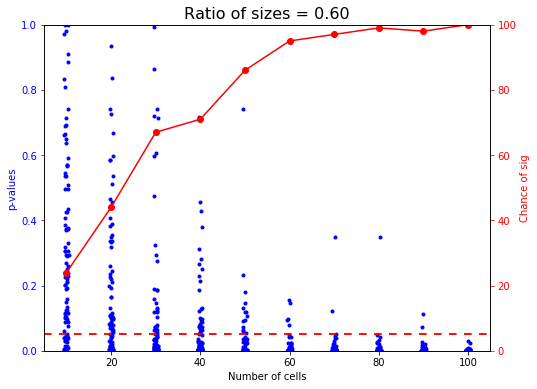

In [19]:
fig,ax= plt.subplots(figsize=(8,6))
ax.set_xlabel("Number of cells")
plot_pval(manwt_pvals,ax)
ax.axhline(0.05,dashes=(5,5),color='red')
ax.set_title("Ratio of sizes = {:.2f}".format(size_ratio),fontsize=16)